### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import plotting_geo
import data_preparation
from scipy.stats import linregress
from tqdm import tqdm
import matplotlib as mpl
from data_preparation import Catalogue

Import data

In [24]:
folder_path_mauro = r'../for_mauro'

df_catalogue = pd.read_csv('../data/the_geysers/reduced_catalogue_clustered.csv', index_col=[0])

# # Original aggregaion
# df_density = pd.read_csv(os.path.join(folder_path_mauro, 'full_results_new_matrix.csv'), index_col=[0])
# time_series = np.array(pd.read_csv('../data/the_geysers/time_series.csv', header=None))
df_labels = pd.read_csv('../data/the_geysers/cluster_labels', index_col = [0])
cluster_labels = np.array([i[0] for i in df_labels.values])
# unique_labels = np.sort(np.unique(cluster_labels))

In [3]:
geo_bound_old = {'lat_min': 38.7,
                'lat_max': 38.9,
                'long_min': -122.95,
                'long_max': -122.65,
                'depth_min': 0,
                'depth_max': 14,
                'step_l': 0.025,
                'step_d': 0.25}


lat_range_old = np.arange(geo_bound_old['lat_min'], geo_bound_old['lat_max'] + geo_bound_old['step_l'], geo_bound_old['step_l'])
long_range_old = np.arange(geo_bound_old['long_min'], geo_bound_old['long_max'] + geo_bound_old['step_l'], geo_bound_old['step_l'])
depth_range_old = np.arange(geo_bound_old['depth_min'], geo_bound_old['depth_max'] + geo_bound_old['step_d'], geo_bound_old['step_d'])

### Recreate new datasets with aggregated geo bounds

In [4]:
geo_bound_agg = {'lat_min': 38.7,
                'lat_max': 38.9,
                'long_min': -122.95,
                'long_max': -122.65,
                'depth_min': 0,
                'depth_max': 14,
                'step_l': 0.05,
                'step_d': 0.5}

lat_range = np.arange(geo_bound_agg['lat_min'], geo_bound_agg['lat_max'] + geo_bound_agg['step_l'], geo_bound_agg['step_l'])
long_range = np.arange(geo_bound_agg['long_min'], geo_bound_agg['long_max'] + geo_bound_agg['step_l'], geo_bound_agg['step_l'])
depth_range = np.arange(geo_bound_agg['depth_min'], geo_bound_agg['depth_max'] + geo_bound_agg['step_d'], geo_bound_agg['step_d'])

lat_max = len(lat_range)
long_max = len(long_range)

In [5]:
df_catalogue.columns
df_catalogue_small = df_catalogue.drop(['#EventID', 'Author',
       'Catalog', 'Contributor', 'MagAuthor', 'cube_id',
       'EventLocationName', 'EventType'], axis = 1)
df_catalogue_small = df_catalogue_small.rename(columns={'Time':'time', 'Latitude': 'latitude', 'Longitude': 'longitude', 'Depth': 'depth', 'MagType': 'magtype', 'Magnitude': 'magnitude'})

In [6]:
catalogue_agg = Catalogue(df_catalogue_small, geo_bounds=geo_bound_agg)
catalogue_agg.index_cubes()
df_catalogue_agg = catalogue_agg.reduced_catalogue
df_catalogue_agg['index_1D'] = df_catalogue_agg.apply(lambda row: data_preparation.index_1d(row, lat_max, long_max), axis=1)
df_density_agg = catalogue_agg.compile_dataset()
time_series_agg = catalogue_agg.time_series()
     

100%|██████████| 997/997 [00:30<00:00, 32.49it/s]


In [7]:
non_zero_time_series = time_series_agg[np.sum(time_series_agg, axis=1)>1000]
np.shape(non_zero_time_series)

(51, 126)

### Clustering check (zero_eq nodes)

In [8]:
# for c in unique_labels:
#     print(f'Cluster {c}: {np.sum(cluster_labels == c)} nodes, {np.sum(time_series[cluster_labels == c])} events, {np.average(time_series[cluster_labels == c])} on average')

In [9]:
# for c in unique_labels:
#     print(f'Cluster {c}: {np.sum(np.sum(time_series[cluster_labels == c], axis = 1) < 2)} nodes')

In [10]:
# time_series_non_zero = time_series[np.sum(time_series, axis = 1) != 0]
# cluster_labels_non_zero = cluster_labels[np.sum(time_series, axis = 1) != 0]
# plotting_geo.plot_means_subplots(time_series_non_zero, list(cluster_labels_non_zero), plotted_clusters=[1, 2])
# plotting_geo.plot_means_subplots(time_series_non_zero, list(cluster_labels_non_zero), plotted_clusters=[3, 4, 5])

### B-value calculations

In [11]:
time_series = time_series_agg
df_catalogue = df_catalogue_agg
df_density = df_density_agg

Select nodes with more than N_EVENTS

In [12]:
N_EVENTS = 1000
MAG_BORDERS = (1.8, 3.0)
BIN_SIZE = 0.2

selection_criterion = np.sum(time_series, axis=1) > N_EVENTS

Reduced dataset creation

In [13]:
selected_1D_indices = np.arange(len(selection_criterion))[selection_criterion]

df_catalogue_selected = df_catalogue[['latitude', 'longitude', 'depth', 'magnitude', 'month', 'year', 'index_1D', 'lat_id', 'long_id', 'depth_id', 'cluster']].copy()
df_catalogue_selected = df_catalogue_selected[df_catalogue_selected.index_1D.isin(selected_1D_indices)]

In [14]:
# df_catalogue_selected['lat_id'] = df_catalogue_selected.apply(lambda row: data_preparation.find_closest_ind(lat_range, row, "latitude"), axis=1)
# df_catalogue_selected['long_id'] = df_catalogue_selected.apply(lambda row: data_preparation.find_closest_ind(long_range, row, "longitude"), axis=1)
# df_catalogue_selected['depth_id'] = df_catalogue_selected.apply(lambda row: data_preparation.find_closest_ind(depth_range, row, "depth"), axis=1)

Iterate through the nodes, calculate the bootstrapped b-value and error

In [15]:
b_values = []
errors = []
bins = np.arange(-1, 5, BIN_SIZE)
bin_labels = [f'{item: .1f}' for item in bins]
df_bins = pd.DataFrame(data = bin_labels, columns=['Magnitudes'])


for i, node in tqdm(enumerate(selected_1D_indices)):
    
    # Select eqs from node
    df_node = df_catalogue_selected[df_catalogue_selected.index_1D == node]
    # Cut the dataset into bins based on the Magnitude, add the bin label as new column (an extract it as np array)
    magnitudes_filtered = pd.cut(df_node['magnitude'], bins, labels=bin_labels[:-1]).to_numpy()
    slopes = []

    # Bootstrap iterations
    for i in range(100):
        # Randomly select the magnitudes with replacement, save as df to use groupby later
        magnitudes_random = np.random.choice(magnitudes_filtered, size=len(magnitudes_filtered), replace=True)
        df_magnitudes_random = pd.DataFrame(magnitudes_random, columns=['Mag_dist'])

        # # Group by value
        # df_hist = df_magnitudes_random.groupby(['Mag_dist'])['Mag_dist'].count()

        # # Create a logarithmic distribution
        # df_hist = df_bins.merge(df_hist, how='left', left_on = 'Magnitudes', right_index=True).fillna(1)
        log_distribution = np.log10(df_magnitudes_random.groupby(['Mag_dist'])['Mag_dist'].count())

        x_lr = np.arange(MAG_BORDERS[0], MAG_BORDERS[1] + BIN_SIZE, BIN_SIZE)
        y_lr = log_distribution[int(MAG_BORDERS[0] / BIN_SIZE)-1: int(MAG_BORDERS[1] / BIN_SIZE)]
        
        if len(y_lr) == 7:
            lin_reg = linregress(x=x_lr, y=y_lr)
            slopes.append(-lin_reg.slope)

    if slopes:
        b_values.append(np.mean(slopes))
        errors.append(np.std(slopes))
    else:    
        b_values.append(0)
        errors.append(0)


51it [00:07,  6.55it/s]


In [16]:
df_bvalues = pd.DataFrame(data = np.transpose([selected_1D_indices.tolist(), b_values, errors]), columns = ['index_1D', 'b_value', 'error'])
df_catalogue_selected = df_catalogue_selected.merge(df_bvalues, how='inner', on='index_1D')

In [17]:
df_nodes = df_catalogue_selected.groupby(['index_1D'])['latitude', 'longitude', 'depth', 'b_value', 'error'].mean()
df_nodes = df_nodes[(df_nodes.b_value > 1) & (df_nodes.error < 0.3)]

C:\Users\macie\AppData\Local\Temp\ipykernel_7280\521858161.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_nodes = df_catalogue_selected.groupby(['index_1D'])['latitude', 'longitude', 'depth', 'b_value', 'error'].mean()


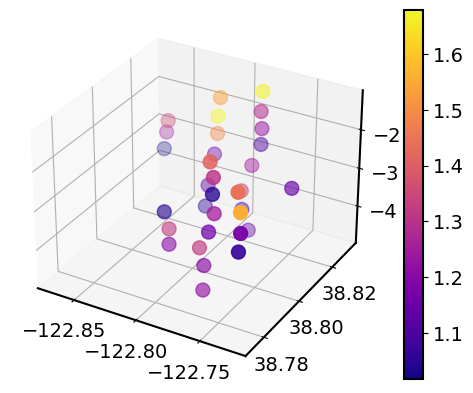

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plot = ax.scatter(df_nodes.longitude, df_nodes.latitude, -df_nodes.depth, c= df_nodes.b_value, cmap='plasma', s = 100)
plt.colorbar(plot)
plt.show()

In [19]:
df_nodes['lat_id'] = df_nodes.apply(lambda row: lat_range[data_preparation.find_closest_ind(lat_range, row, "latitude")], axis=1)
df_nodes['long_id'] = df_nodes.apply(lambda row: long_range[data_preparation.find_closest_ind(long_range, row, "longitude")], axis=1)
df_nodes['depth_id'] = df_nodes.apply(lambda row: depth_range[data_preparation.find_closest_ind(depth_range, row, "depth")], axis=1)

Depth layer plot

In [20]:
df_catalogue_old = pd.read_csv('../data/the_geysers/reduced_catalogue_clustered.csv', index_col=[0])
df_density_old = pd.read_csv(os.path.join(folder_path_mauro, 'full_results_new_matrix.csv'), index_col=[0])

C:\Users\macie\AppData\Local\Temp\ipykernel_7280\1377017932.py:48: RuntimeWarning: divide by zero encountered in log10
  ax.contour(X_cat[:-1, :-1]+(geo_bound_old['step_l']/2), Y_cat[:-1, :-1]+(geo_bound_old['step_l']/2), np.log10(H_cat.T), 15, cmap='Greys', alpha = 0.5)
c:\Users\macie\.conda\envs\geysers\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\macie\AppData\Local\Temp\ipykernel_7280\1377017932.py:48: RuntimeWarning: divide by zero encountered in log10
  ax.contour(X_cat[:-1, :-1]+(geo_bound_old['step_l']/2), Y_cat[:-1, :-1]+(geo_bound_old['step_l']/2), np.log10(H_cat.T), 15, cmap='Greys', alpha = 0.5)
C:\Users\macie\AppData\Local\Temp\ipykernel_7280\1377017932.py:48: RuntimeWarning: divide by zero encountered in log10
  ax.contour(X_cat[:-1, :-1]+(geo_bound_old['step_l']/2), Y_cat[:-1, :-1]+(geo_bound_old['step_l']/2), np.log10(H_cat.T), 15, cmap='Greys', alph

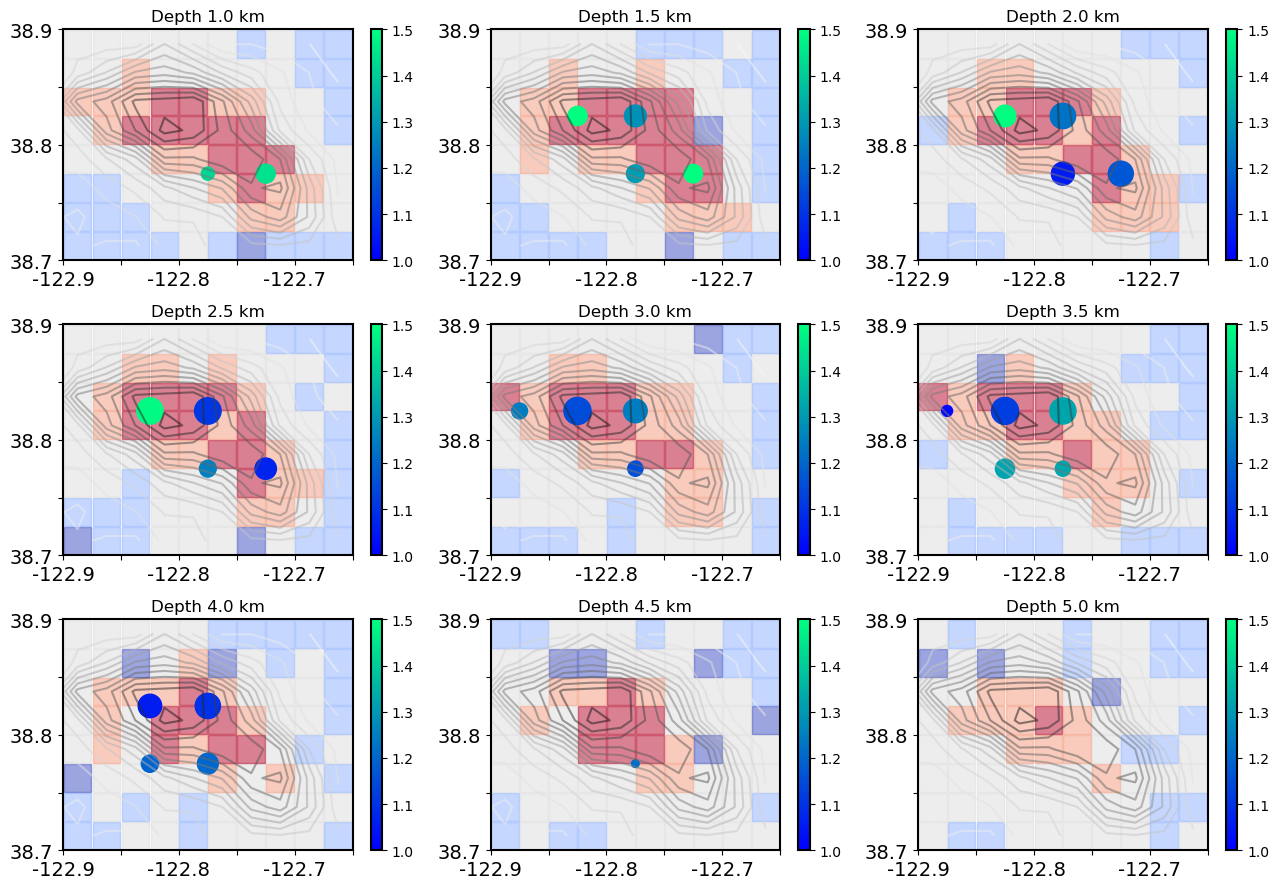

In [21]:
layers = np.arange(1, 5.5, 0.5)
fig, axs = plt.subplots(nrows = 3, ncols=3, figsize = (13, 9))

mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.linewidth'] = 1.5


# Definition of meshgrid for eq_density
x_contour = np.arange(geo_bound_old['long_min'], geo_bound_old['long_max'] + geo_bound_old['step_l'], geo_bound_old['step_l'])
y_contour = np.arange(geo_bound_old['lat_min'], geo_bound_old['lat_max'] + geo_bound_old['step_l'], geo_bound_old['step_l'])
z_contour = - np.arange(geo_bound_old['depth_min'], geo_bound_old['depth_max'] + geo_bound_old['step_d'], geo_bound_old['step_d'])  

x_cat = df_catalogue_old['Longitude']
y_cat = df_catalogue_old['Latitude']
z_cat = df_catalogue_old['Depth']

H_cat, xedges_cat, yedges_cat = np.histogram2d(np.array(x_cat), np.array(y_cat), bins=(x_contour, y_contour))
H_cat_depth, xedges_cat_depth, zedges_cat_depth = np.histogram2d(np.array(x_cat), -np.array(z_cat), bins=(x_contour,np.flip(z_contour)))
X_cat, Y_cat = np.meshgrid(xedges_cat, yedges_cat)  
X_cat_depth, Z_cat_depth = np.meshgrid(xedges_cat_depth, zedges_cat_depth)



# Plot definition
for ax, layer in zip(axs.ravel(), layers):
    
    # # Cluster members
    # df_density_layer = df_density_old[df_density_old.depth == layer].copy()
    # df_cluster_layer = df_density_layer.groupby(['index_1D'])[['lat', 'long', 'cluster']].mean()
    # df_cluster_layer['cluster'] = df_cluster_layer['cluster'].astype(int)
    # # df_cluster_layer = df_cluster_layer[df_cluster_layer.cluster == 1]
    # plot_cluster = ax.scatter(df_cluster_layer.long + 0.0125, df_cluster_layer.lat + 0.0125, c=df_cluster_layer.cluster, s = 400, alpha=0.3, marker='s')

    df_density_layer = df_density_old[df_density_old.depth == layer].copy()
    df_cluster_layer = df_density_layer.groupby(['index_1D'])[['lat', 'long', 'cluster']].mean()
    df_cluster_layer['cluster'] = df_cluster_layer['cluster'].astype(int)
    map_cluster = np.zeros(np.shape(X_cat[:-1, :-1]))

    df_test = df_density_layer.drop_duplicates(subset=['index_1D'])
    for index, row in df_test[['lat_id', 'long_id', 'cluster']].iterrows():
        map_cluster[row['lat_id'], row['long_id']] = row['cluster']

    map_cluster[map_cluster == 0] = 2

    plot_cluster = ax.scatter(X_cat[:-1, :-1]+0.0125, Y_cat[:-1, :-1]+0.0125, c=map_cluster.astype(int), s = 400, marker='s', cmap='coolwarm', alpha = 0.5)

    # Density contour
    ax.contour(X_cat[:-1, :-1]+(geo_bound_old['step_l']/2), Y_cat[:-1, :-1]+(geo_bound_old['step_l']/2), np.log10(H_cat.T), 15, cmap='Greys', alpha = 0.5)


    # B-values scatter
    df_layer = df_nodes[df_nodes.depth_id == layer].copy()
    plot = ax.scatter(df_layer.long_id + 0.025, df_layer.lat_id + 0.025, c= df_layer.b_value, cmap='winter', s = 500 * (1 - 5 * df_layer.error),  vmin = 1, vmax = 1.5)

    # Visuals
    ax.set_xlim(-122.9, -122.7)
    ax.set_ylim(38.7, 38.9)
    ax.set_xticks(np.arange(-122.9, -122.61, 0.05))
    ax.set_xticklabels(["-122.9", "", "-122.8", "", "-122.7", ""])
    ax.set_yticks(np.arange(38.7, 38.91, 0.05))
    ax.set_yticklabels(["38.7", "", "38.8", "", "38.9"])
    ax.set_title(f'Depth {layer} km')
    plt.colorbar(plot)

plt.tight_layout()
plt.show()

In [22]:
# Create a node dataframe for each coordinate
coords = np.array(np.meshgrid(long_range_old[:-2], lat_range_old[:-2], depth_range_old[:-2])).T.reshape(-1, 3)
coords_id = np.array(np.meshgrid(np.arange(len(long_range_old)-2), np.arange(len(lat_range_old)-2), np.arange(len(depth_range_old)-2))).T.reshape(-1, 3)
df_nodes = pd.DataFrame(data = np.c_[coords, coords_id], columns = ['long', 'lat', 'depth', 'long_id', 'lat_id', 'depth_id'])
df_nodes['index_1D'] = df_nodes.apply(lambda row: data_preparation.index_1d(row, len(lat_range_old)-2, len(long_range_old)-2), axis=1)

s_cluster = df_density_summary.groupby(['index_1D'])['cluster'].mean()


# Reset index before merging
df_nodes = df_nodes.reset_index(drop=True)
df_nodes = df_nodes.merge(s_cluster, how='left', left_on='index_1D', right_index=True)

# Fill empty clusters with 2
df_nodes.cluster = df_nodes.cluster.fillna(2)

NameError: name 'df_density_summary' is not defined

### Other b-value calculation

- Repeat the procedure

In [ ]:
time_series = time_series_agg
df_catalogue = df_catalogue_agg
df_density = df_density_agg

In [ ]:
N_EVENTS = 1000
MAG_BORDERS = (1.8, 3.0)
BIN_SIZE = 0.2

selection_criterion = np.sum(time_series, axis=1) > N_EVENTS

In [ ]:
selected_1D_indices = np.arange(len(selection_criterion))[selection_criterion]

df_catalogue_selected = df_catalogue[['latitude', 'longitude', 'depth', 'magnitude', 'month', 'year', 'index_1D', 'lat_id', 'long_id', 'depth_id', 'cluster']].copy()
df_catalogue_selected = df_catalogue_selected[df_catalogue_selected.index_1D.isin(selected_1D_indices)]

- Calculate the b-value

In [ ]:
b_values = []
errors = []
bins = np.arange(-1, 5, BIN_SIZE)
bin_labels = [f'{item: .1f}' for item in bins]
df_bins = pd.DataFrame(data = bin_labels, columns=['Magnitudes'])


for i, node in tqdm(enumerate(selected_1D_indices)):
    
    # Select eqs from node
    df_node = df_catalogue_selected[df_catalogue_selected.index_1D == node]
    # Cut the dataset into bins based on the Magnitude, add the bin label as new column (an extract it as np array)
    magnitudes_filtered = pd.cut(df_node['magnitude'], bins, labels=bin_labels[:-1]).to_numpy()
    slopes = []

    # Bootstrap iterations
    for i in range(100):
        # Randomly select the magnitudes with replacement, save as df to use groupby later
        magnitudes_random = np.random.choice(magnitudes_filtered, size=len(magnitudes_filtered), replace=True)
        df_magnitudes_random = pd.DataFrame(magnitudes_random, columns=['Mag_dist'])

        magnitudes_array = df_magnitudes_random.groupby(['Mag_dist'])['Mag_dist'].count().values
        cum_sum_magnitudes_array = np.flip(np.cumsum(np.flip(magnitudes_array)))
        
        # # Group by value
        # df_hist = df_magnitudes_random.groupby(['Mag_dist'])['Mag_dist'].count()

        # # Create a logarithmic distribution
        # df_hist = df_bins.merge(df_hist, how='left', left_on = 'Magnitudes', right_index=True).fillna(1)
        log_distribution = np.log10(cum_sum_magnitudes_array/cum_sum_magnitudes_array[0])

        x_lr = np.arange(MAG_BORDERS[0], MAG_BORDERS[1] + BIN_SIZE, BIN_SIZE)
        y_lr = log_distribution[int(MAG_BORDERS[0] / BIN_SIZE)-1: int(MAG_BORDERS[1] / BIN_SIZE)]
        
        if len(y_lr) == 7:
            lin_reg = linregress(x=x_lr, y=y_lr)
            slopes.append(-lin_reg.slope)

    if slopes:
        b_values.append(np.mean(slopes))
        errors.append(np.std(slopes))
    else:    
        b_values.append(0)
        errors.append(0)


51it [00:07,  6.89it/s]


- Manipulate the data (add the columns to the dataframe)

In [ ]:
df_bvalues = pd.DataFrame(data = np.transpose([selected_1D_indices.tolist(), b_values, errors]), columns = ['index_1D', 'b_value', 'error'])
df_catalogue_selected = df_catalogue_selected.merge(df_bvalues, how='inner', on='index_1D')


In [ ]:
df_nodes = df_catalogue_selected.groupby(['index_1D'])[['latitude', 'longitude', 'depth', 'b_value', 'error']].mean()
df_nodes = df_nodes[(df_nodes.b_value > 0) & (df_nodes.error < 0.3)]

- Plots

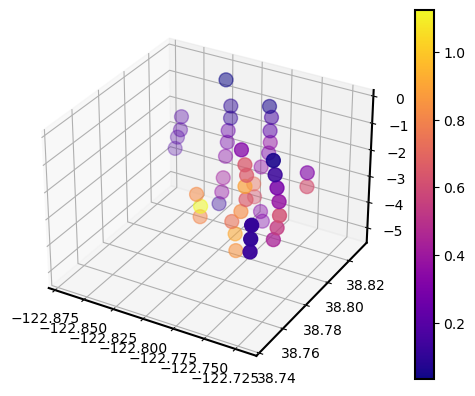

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plot = ax.scatter(df_nodes.longitude, df_nodes.latitude, -df_nodes.depth, c= df_nodes.b_value, cmap='plasma', s = 100)
plt.colorbar(plot)
plt.show()

In [ ]:
len(np.max(time_series, axis = 0))

126